In [152]:
import os
from os import path
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

# Если переменная BASE_DIR не определена, то устанавливаем её как текущий каталог
if not 'BASE_DIR' in locals():
    BASE_DIR = os.path.abspath(os.curdir)

In [153]:
# Если текущий каталог является BASE_DIR, то переходим на уровень выше
if os.path.abspath(os.curdir) == BASE_DIR:
    os.chdir('../')

# Определяем путь к каталогу с данными
dirname = os.path.abspath(os.curdir) + r'\data'

# Читаем данные из CSV файла
df = pd.read_csv(path.join(os.sep, dirname, 'Annual snowfall in Chicago 1939 to 1978.csv'))

# Оставляем только колонку 'x'
df = df['x']
df.head()

0    33.9
1    31.0
2    52.5
3    29.8
4    45.2
Name: x, dtype: float64

In [154]:
df.describe()

count    40.000000
mean     41.442500
std      15.714584
min      14.300000
25%      30.700000
50%      38.000000
75%      52.275000
max      82.300000
Name: x, dtype: float64

In [155]:
# Импортируем функцию для проведения теста Дики-Фуллера
from statsmodels.tsa.stattools import adfuller

# Функция для проведения теста Дики-Фуллера
def Fuller(name:str, df:pd.DataFrame):
    alpha = 0.05
    if hasattr(df, 'columns'):
        df = df[df.columns[0]]
    print(f'Тест Дики-Фуллера ряда {name} :')
    # определяем результат значения теста из библиотеки с учетом
    dftest = adfuller(df, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

    if dfoutput["p-value"] < alpha:
        print(f"Значение p меньше {alpha * 100}%. Ряд стационарный.")
    else:
        print(f"Значение p больше {alpha*100}%. Ряд не стационарный.")

        # Проводим тест Дики-Фуллера для исходных данных
Fuller('Snowfall', df)

Тест Дики-Фуллера ряда Snowfall :
Test Statistic                -5.830728e+00
p-value                        3.980943e-07
#Lags Used                     0.000000e+00
Number of Observations Used    3.900000e+01
Critical Value (1%)           -3.610400e+00
Critical Value (5%)           -2.939109e+00
Critical Value (10%)          -2.608063e+00
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


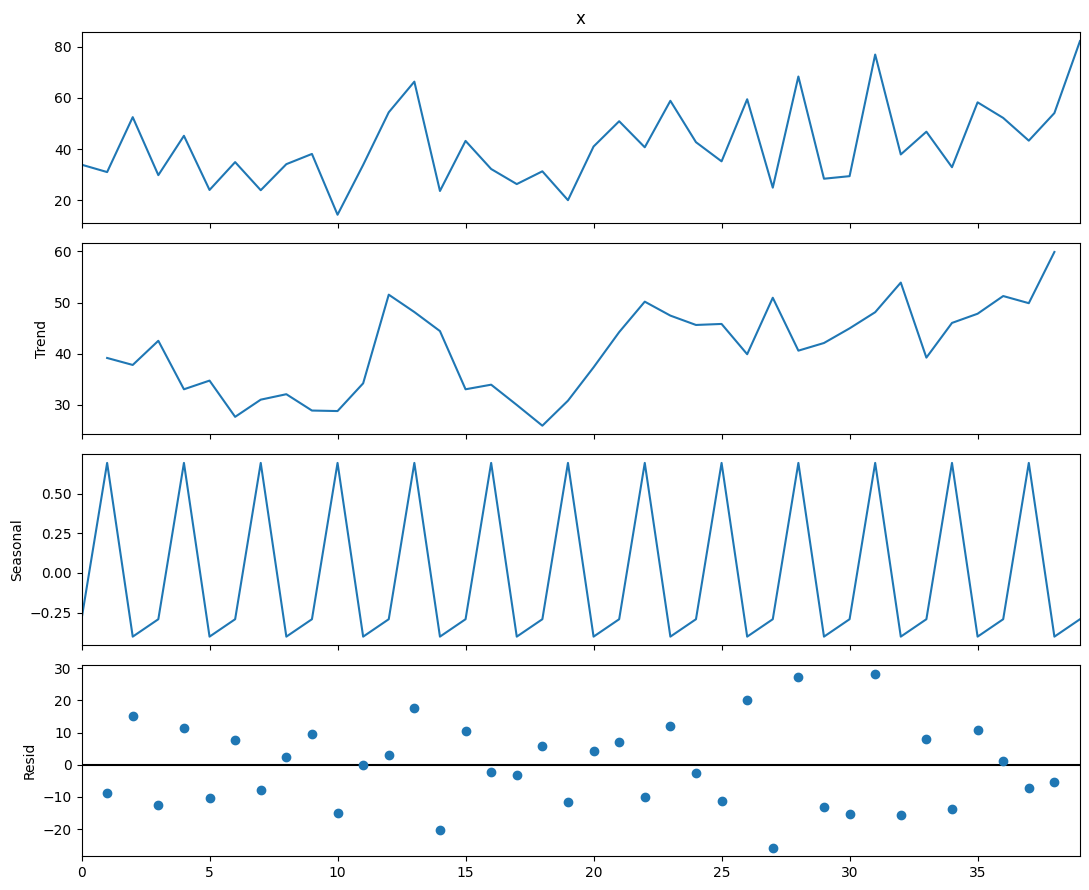

In [156]:
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9
decompose = seasonal_decompose(df,
                               period=3)
decompose.plot()
plt.show()

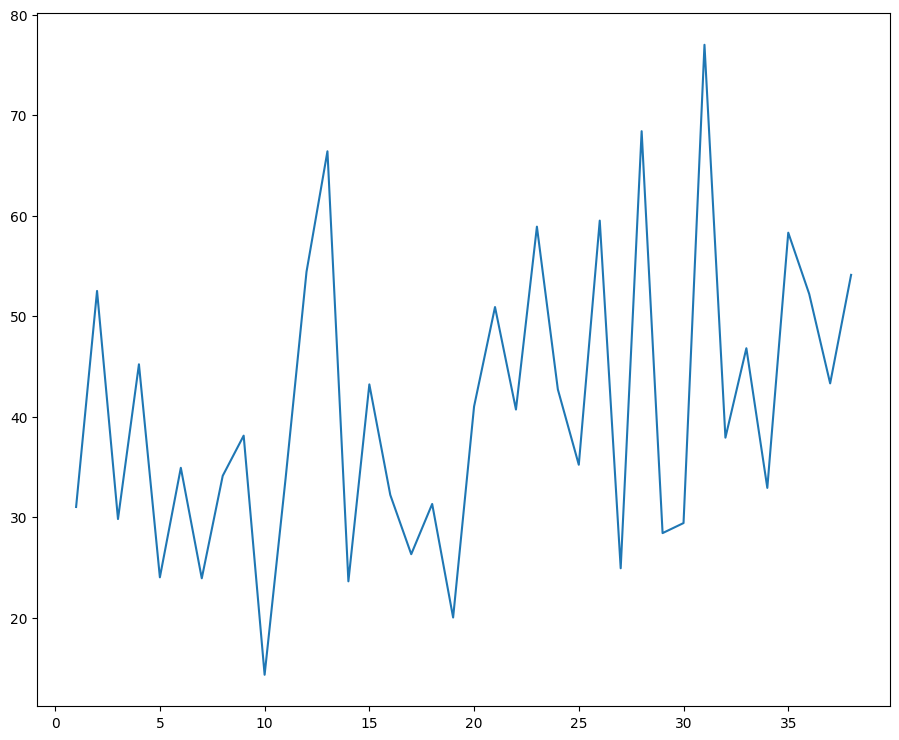

In [157]:
# Собираем аддитивный ряд
additive = decompose.trend + decompose.seasonal + decompose.resid
additive.plot()
plt.show()


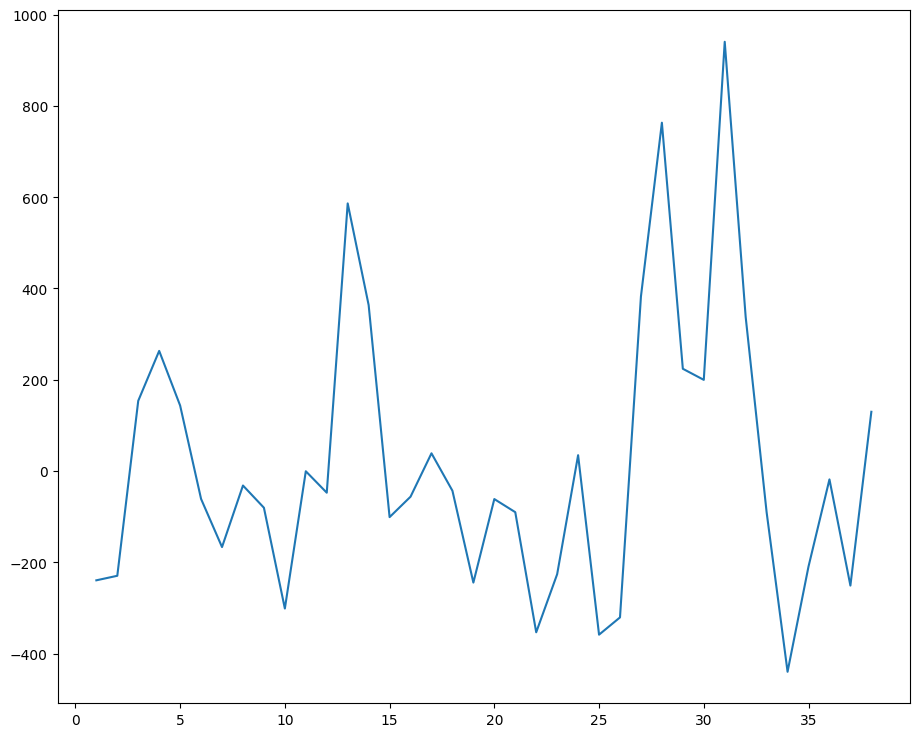

In [158]:
# Собираем мультипликативный ряд
multiplicative = decompose.trend * decompose.seasonal * decompose.resid
multiplicative.plot()
plt.show()

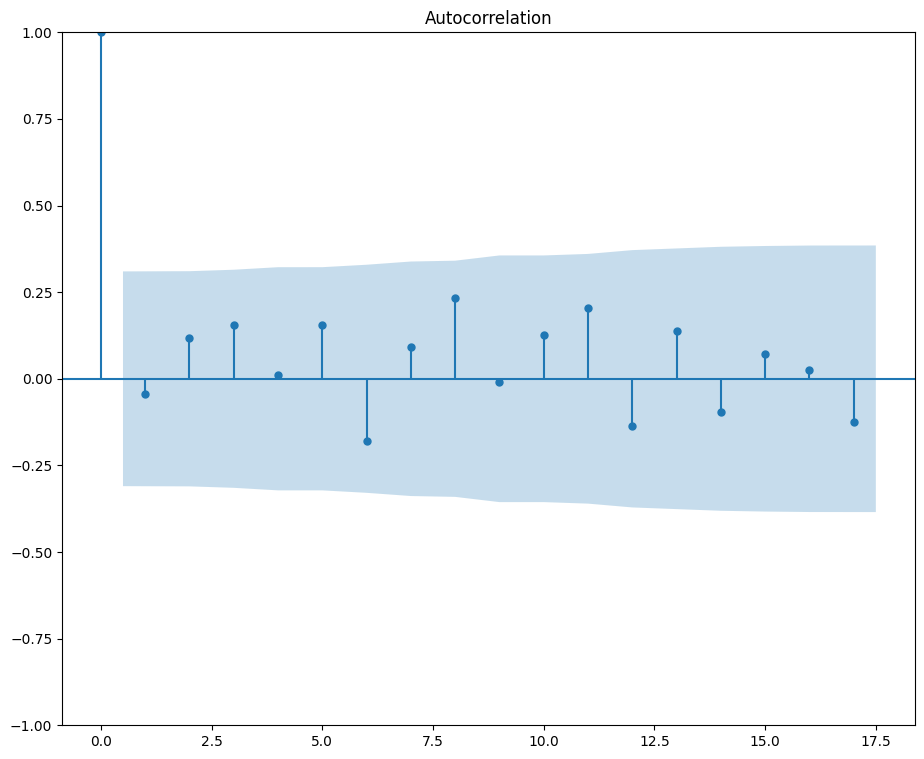

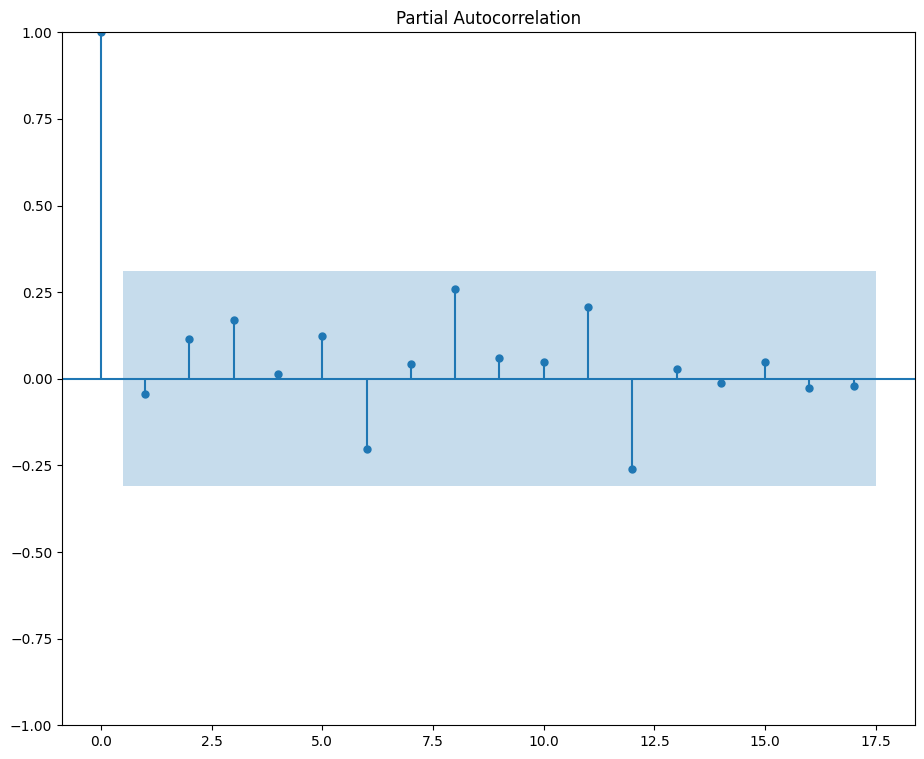

In [159]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Автокорреляция
plot_acf(df)
plt.show()

# Частичная автокорреляция
plot_pacf(df)
plt.show()